# **Final Project in Integrated Energy Grids - 46770**

# F.
### Connect your country with, at least, two neighbouring countries. 
You can connect them using HVAC lines, HVDC links or gas pipelines. Use a linear representation of power flow or gas flow. 
You can assume that the generation capacities in the neighbouring countries are fixed or optimize the whole system. You can also include fixed interconnection capacities or optimize them with the generators' capacities. Discuss your results.

In [1]:
 # Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypsa
import gurobipy as gp
from geopy.geocoders import Nominatim

import functions as f
    # This includes e.g. annuity and generator data

#### **We connect GBR to France and Norway**

### Load data that was always used in the previous file. It has been moved to a .py-file for simplicity.

In [2]:
# Read wind, solar, and demand data from the three countries
countries = ['GBR', 'FRA', 'NOR']
year = '2015'
hours_in_year = pd.date_range(f'{year}-01-01 00:00Z',
                              f'{year}-12-31 23:00Z',
                              freq='h')

########## Initialize network -- to use the snapshots ##########
network_F = pypsa.Network()

# Define snapshots and electricity carrier
network_F.set_snapshots(hours_in_year.values)
network_F.add("Carrier",
              "AC",
              color="black",
              co2_emissions=0)

########## Continue loading data ##########
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime

df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)

df_solar = pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)

# Load data for the capacity factors and define lists useful for dynamic definition of carriers and generators
CF_wind = {country:
           df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network_F.snapshots]]
           for country in countries}
CF_solar = {country:
            df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network_F.snapshots]]
            for country in countries}
CFs = [CF_wind, CF_solar]

# Useful lists and dict
VRE_techs = ['onshorewind', 'solar']
CF_dict = {'onshorewind': CF_wind, 'solar': CF_solar}
techs_labels = ['onshorewind', 'solar', 'OCGT', 'coal', 'nuclear', 'biomass'] # NG plant = natural gas plant
techs_labels_storageunits = ['Carnot battery (Molten salt)', 'Li-ion battery', ' Vanadium rfb']
carriers =     ['onshorewind', 'solar', 'gas',  'coal', 'nuclear', 'wood chips']
techs_colors = ['blue',        'orange','brown','grey', 'purple',  'green']

(dict_capital_costs_annualized,
 dict_marginal_costs,
 dict_efficiencies,
 CO2_emissions
) = f.load_generator_data(techs_labels)
    # The "techs_labels" is not actually dynamic. 
    # Don't just change the technologies used!!!

(dict_capital_costs_annualized_storageunits,
 efficiencies_in,
 efficiencies_out,
 Crates,
 hourly_losses
) = f.load_storage_units_data(techs_labels_storageunits)
    # The "techs_labels_storageunits" is not actually dynamic. 
    # Don't just change the technologies used!!!

<Axes: title={'center': 'Capacity factors of ONSHORE WIND'}, xlabel='utc_time'>

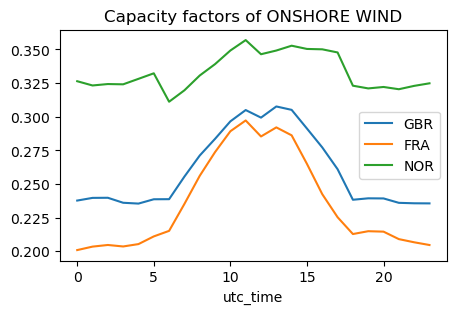

In [3]:
df_w=pd.DataFrame(CFs[0])
df_w.groupby(df_w.index.hour).mean().plot(title='Capacity factors of ONSHORE WIND',figsize=(5,3))

<Axes: title={'center': 'Capacity factors of SOLAR'}, xlabel='utc_time'>

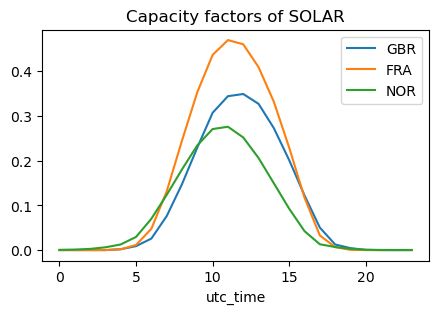

In [4]:
df_s=pd.DataFrame(CFs[1])
df_s.groupby(df_s.index.hour).mean().plot(title='Capacity factors of SOLAR',figsize=(5,3))

<Axes: title={'center': 'Electricity demand'}, xlabel='utc_time', ylabel='MW'>

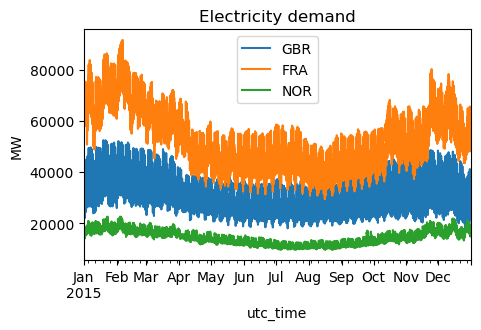

In [5]:
df_elec[countries].plot(title='Electricity demand',ylabel=('MW'),figsize=(5,3))

In [6]:
# Get the coordinates of the countries to use for plotting. Additional countries included for dynamic reasons.
country_coords = {  # a fully set of coordinates is probably available somewhere online
    'GBR': (52.5, -1.5),
    'FRA': (46.5, 2.5),
    'NOR': (61.0, 10.0),
    'PRT': (38.74, -9.15),
    'DNK': (55.67, 12.57)
}

### Define the network using the data from the previous cell

In [7]:
# Define carriers
network_F.add("Carrier", carriers, color=techs_colors, co2_emissions=CO2_emissions, overwrite=True)

for country in countries:
    # Define BUSes
    network_F.add("Bus",
                  f"{country} electricity bus",
                  y=country_coords[country][0],
                  x=country_coords[country][1],
                  carrier="AC",
                  overwrite=True)
    
    # Define electricity LOADs
    network_F.add("Load",
                f"{country} electricity load",
                carrier="AC",
                bus=f"{country} electricity bus",
                p_set=df_elec[country].values,
                overwrite=True)

    # Define GENERATORs
    for i,tech in enumerate(techs_labels):
        network_F.add("Generator",
                      f"{country} {tech}",
                      bus=f"{country} electricity bus",
                      p_nom_extendable=True,
                      #p_nom_extendable=(False if tech=='biomass' and country!='GBR' else True), # to compare with task D)
                      carrier=carriers[i],
                      capital_cost = dict_capital_costs_annualized[tech],
                      marginal_cost = dict_marginal_costs[tech],
                      p_max_pu = (CFs[i][country].values if tech in VRE_techs else 1),
                      efficiency = dict_efficiencies[tech],
                      overwrite=True) # kept  in case of re-running the code

    # Define STORAGEs
    for i, storage in enumerate(techs_labels_storageunits):
        network_F.add("StorageUnit",
                      f"{country} {storage}",
                      bus=f"{country} electricity bus",
                      p_nom_extendable=True,
                      carrier="AC",
                      capital_cost=dict_capital_costs_annualized_storageunits[storage],
                      efficiency_store=efficiencies_in[storage],
                      efficiency_dispatch=efficiencies_out[storage],
                      max_hours=1/Crates[i],
                      cyclic_state_of_charge=True,
                      standing_loss=hourly_losses[storage],  # <- this value quantitatively indicates whether storage is diurnal/seasonal
                      overwrite=True) # for re-running the code

### Before defining the **hydro** storage we need to get some data:

In [8]:
# Find hydro inflows from: https://github.com/martavp/integrated-energy-grids/blob/main/integrated-energy-grids/Problems/data/inflow/Hydro_Inflow_FR.csv
hydro_countries = countries

df_inflow = {}

for hydro_country in hydro_countries:
    df_inflow[hydro_country] = pd.read_csv(f"data/Hydro_Inflow_{hydro_country}.csv")
    df_inflow[hydro_country]['Date'] = pd.to_datetime(df_inflow[hydro_country][['Year', 'Month', 'Day']])
    df_inflow[hydro_country].set_index('Date', inplace=True)  # allows us to choose a year

Date
2003    Axes(0.125,0.11;0.775x0.77)
2004    Axes(0.125,0.11;0.775x0.77)
2005    Axes(0.125,0.11;0.775x0.77)
2006    Axes(0.125,0.11;0.775x0.77)
2007    Axes(0.125,0.11;0.775x0.77)
2008    Axes(0.125,0.11;0.775x0.77)
2009    Axes(0.125,0.11;0.775x0.77)
2010    Axes(0.125,0.11;0.775x0.77)
2011    Axes(0.125,0.11;0.775x0.77)
2012    Axes(0.125,0.11;0.775x0.77)
Name: Inflow [GWh], dtype: object

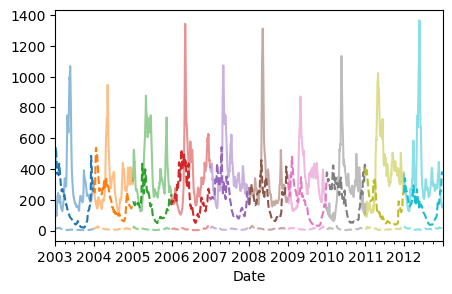

In [9]:
df_inflow["NOR"]['Inflow [GWh]'].groupby(df_inflow[hydro_country].index.year).plot(figsize=(5,3), alpha=0.5)
df_inflow["FRA"]['Inflow [GWh]'].groupby(df_inflow[hydro_country].index.year).plot(figsize=(5,3), linestyle='--')
df_inflow["GBR"]['Inflow [GWh]'].groupby(df_inflow[hydro_country].index.year).plot(figsize=(5,3), alpha=0.5, linestyle='--')

In [10]:
hydro_countries = ['FRA', 'NOR']  # UK has barely any hydro...
df_inflow_hourly = pd.DataFrame({hydro_country:np.zeros(8760) for hydro_country in hydro_countries}, index=hours_in_year)
hydro_year = 2010
for hydro_country in hydro_countries:
    df_inflow_hourly.loc[::24,hydro_country] = (df_inflow[hydro_country][df_inflow[hydro_country].index.year==hydro_year]['Inflow [GWh]'] * 1e3).values  # GWh -> MWh
print(df_inflow_hourly.head(26))

                                FRA       NOR
2015-01-01 00:00:00+00:00  347679.0  145695.0
2015-01-01 01:00:00+00:00       0.0       0.0
2015-01-01 02:00:00+00:00       0.0       0.0
2015-01-01 03:00:00+00:00       0.0       0.0
2015-01-01 04:00:00+00:00       0.0       0.0
2015-01-01 05:00:00+00:00       0.0       0.0
2015-01-01 06:00:00+00:00       0.0       0.0
2015-01-01 07:00:00+00:00       0.0       0.0
2015-01-01 08:00:00+00:00       0.0       0.0
2015-01-01 09:00:00+00:00       0.0       0.0
2015-01-01 10:00:00+00:00       0.0       0.0
2015-01-01 11:00:00+00:00       0.0       0.0
2015-01-01 12:00:00+00:00       0.0       0.0
2015-01-01 13:00:00+00:00       0.0       0.0
2015-01-01 14:00:00+00:00       0.0       0.0
2015-01-01 15:00:00+00:00       0.0       0.0
2015-01-01 16:00:00+00:00       0.0       0.0
2015-01-01 17:00:00+00:00       0.0       0.0
2015-01-01 18:00:00+00:00       0.0       0.0
2015-01-01 19:00:00+00:00       0.0       0.0
2015-01-01 20:00:00+00:00       0.

In [11]:
capital_cost_hydro_annualized = f.load_hydro_cost()  # €/MW/a
capital_cost_hydro_annualized*1, dict_capital_costs_annualized  # it's rather cheap compared to the other technologies

(109128.85760044833,
 {'onshorewind': 110644.32615672055,
  'solar': 22980.056511694245,
  'OCGT': 38447.402240719224,
  'coal': 197904.8110235642,
  'nuclear': 695334.7173583676,
  'biomass': 273992.9814855853})

In [12]:
# Hydro storage in Norway and France:

hydro_max = {"NOR": 26712, "FRA": 8787}  # Assumed to be the current level: from 'ENTSO-E Transparency Platform - Installed Capacity per Production Type'

network_F.add("Carrier",
              "water",
              color="cyan",
              co2_emissions=0,
              overwrite=True)

for hydro_country in hydro_countries:
    network_F.add("Bus",
                  f"{hydro_country} water bus",
                  y=country_coords[hydro_country][0],
                  x=country_coords[hydro_country][1],
                  carrier="water",
                  overwrite=True)

    network_F.add("Store",
                  f"{hydro_country} water reservoir",
                  bus=f"{hydro_country} water bus",
                  e_nom=0, # CHANGED2
                  e_nom_extendable=True, # CHANGED2
                  e_cyclic=True,  # CHANGED2 initial energy is the energy at the final snapshot
                  marginal_cost=0,
                  capital_cost=0,  # costs are modelled as $/kW on the link instead
                  standing_loss=0,  # this seems a reasonable assumption
                  overwrite=True)

    network_F.add("Link",
                  f"{hydro_country} hydro2p",  # hydro-to-power
                  bus0=f"{hydro_country} water bus",
                  bus1=f"{hydro_country} electricity bus",
                  carrier="water",
                  efficiency=1,  # the power is assumed to have been given in MWh_e
                  p_nom=0,
                  p_nom_extendable=True,
                  #p_nom_extendable=False, # to compare with task D)
                  p_nom_max=hydro_max[hydro_country],  # Assumed to be the current level: from 'ENTSO-E Transparency Platform - Installed Capacity per Production Type'
                  marginal_cost=0,  # assumption, it might be too rough
                  capital_cost=capital_cost_hydro_annualized, # CHANGED2
                  overwrite=True)

    # dummy components because generator couldn't work...
    network_F.add("Bus",
                  f"dummy {hydro_country} water bus",
                  y=country_coords[hydro_country][0],
                  x=country_coords[hydro_country][1],
                  carrier="water",
                  overwrite=True)

    network_F.add("Store",  # A generator component is used to simulate the water inflow
                 f"dummy {hydro_country} water inflow",
                 bus=f"dummy {hydro_country} water bus",
                 e_nom=df_inflow_hourly[hydro_country].values.flatten().sum(),
                 e_nom_extendable=False,
                 e_initial=df_inflow_hourly[hydro_country].values.flatten().sum(),
                 marginal_cost=0,
                 capital_cost=0,
                 standing_loss=0,
                 overwrite=True)

    network_F.add("Link",
                f"dummy {hydro_country} hydro2p",  # hydro-to-power
                bus0=f"dummy {hydro_country} water bus",
                bus1=f"{hydro_country} water bus",
                carrier="water",
                efficiency=1,  # the power is already given in MWh_e
                p_nom=max(df_inflow_hourly[hydro_country].values.flatten()),
                p_max_pu=df_inflow_hourly[hydro_country].values.flatten() / max(df_inflow_hourly[hydro_country].values.flatten()),
                p_nom_extendable=False,
                marginal_cost=0,  # assumption, it might be too rough
                capital_cost=0,
                overwrite=True)

In [13]:
# CABLE
# Assuming a line between the first and all other countries
line_pairs = [(countries[0],country1) for country1 in countries[1:]]
distances = {f"({line_pair[0]},{line_pair[1]})":dist for line_pair,dist in zip(line_pairs,[73, 730])}  # km, from https://en.wikipedia.org/wiki/HVDC_Cross-Channel, https://en.wikipedia.org/wiki/North_Sea_Link

# This Energinet note states that the Viking Link cost 15 bDKK and that its capacity is 1400 MW.
#   Given the distance of 621 km we can determine a cost per MW per km. By annualizing afterwards and multiplying by distance, we'll arrive at €/MW/a.
DKK2Euro = 1/7.5
cable_cost_per_km = 15e9*DKK2Euro / 1400 / 621  # €/MWkm
lifetime_cable = 40  # years according to the relevant Technology Catalogue from the DEA
capital_cost_cable_annualized = {f"({line_pair[0]},{line_pair[1]})":
                                 f.annuity(lifetime_cable, 0.07)
                                 *distances[f"({line_pair[0]},{line_pair[1]})"]
                                 *cable_cost_per_km
                                 *(1+0.03)
                                 for line_pair in line_pairs}  # €/MW/a

# Define LINEs
for line_pair in line_pairs:
    network_F.add(
        "Line",
        f"({line_pair[0]},{line_pair[1]})",
        bus0=f"{line_pair[0]} electricity bus",
        bus1=f"{line_pair[1]} electricity bus",
        length=distances[f"({line_pair[0]},{line_pair[1]})"],
        s_nom=0,
        s_nom_extendable=True,
        #s_nom_extendable=False,  # to compare with task D)
        x=1,
        r=1,
        capital_cost=capital_cost_cable_annualized[f"({line_pair[0]},{line_pair[1]})"],
        overwrite=True
    )

In [14]:
lifetime_cable, distances, np.array(list(capital_cost_cable_annualized.values())) / np.array(list(distances.values())), capital_cost_cable_annualized, 

(40,
 {'(GBR,FRA)': 73, '(GBR,NOR)': 730},
 array([177.73041877, 177.73041877]),
 {'(GBR,FRA)': 12974.320570293905, '(GBR,NOR)': 129743.20570293903})

In [15]:
capital_cost_cable_annualized, capital_cost_hydro_annualized, dict_capital_costs_annualized, dict_capital_costs_annualized_storageunits

({'(GBR,FRA)': 12974.320570293905, '(GBR,NOR)': 129743.20570293903},
 109128.85760044833,
 {'onshorewind': 110644.32615672055,
  'solar': 22980.056511694245,
  'OCGT': 38447.402240719224,
  'coal': 197904.8110235642,
  'nuclear': 695334.7173583676,
  'biomass': 273992.9814855853},
 {'Carnot battery (Molten salt)': 37121.629749659936,
  'Li-ion battery': 116667.97921321695,
  ' Vanadium rfb': 143892.57600301894})

In [16]:
# Keep track of biomass usage

# Before we used: 
'''
PJ2MWh = 10**9 / 60**2
biomass_imported = 0.4
biomass_available = 294 * PJ2MWh * (1-biomass_imported)  # MWh_th
'''

# But now we want to make it more DYNAMIC:
    # We limit the use of wood chips by:
    # 1) assuming that all solid biomass is wood chips. Simply referred to as "biomass" in script.
    # 2) assuming that all internally produced solid biomass (97.5% of solid biomass consumption) is sustainable and all imported is not and thus forbidden
    # 3) assuming that the 4.2 EJ of solid biomass is in thermal/raw units (MWh_h)
    # Using 2024 numbers from https://www.ieabioenergy.com/wp-content/uploads/2025/01/CountryReport2024_EU27_final_v2.pdf
EJ2MWh = 10**12 / 60**2  # purely unit conversion factor
biomass_imported_EU = 0.025
biomass_available_EU = 4.2 * EJ2MWh * (1-0.025)  # MWh_th
# We assume that biomass has the same potential to grow anywhere in Europe and so the EU numbers 
#   can be used to determine a biomass per land area-factor by weighting the country sizes
country_sizes = pd.read_csv('data/country_sizes.csv')
country_sizes.index = country_sizes['code']
biomass_density = biomass_available_EU / country_sizes['area'][country_sizes['EU']==True].sum()  # MWh/km2
biomass_available = biomass_density * country_sizes.loc[countries]['area'].sum()  # MWh
#biomass_available = biomass_density * country_sizes.loc['GBR']['area'].sum()  # MWh
    # Replace 'countries' with 'GBR' and also avoid biomass 
    #   investments from neighbours, in order to get the same
    #   optimization result as obtained in task D).

network_F.carriers["track_biomass"] = [0, 0, 0, 0, 0, 0, 1.0, 0]  # count 1 MWh for each MWh of wood chips used and none for the others

network_F.add(
    "GlobalConstraint",
    "BiomassLimit",
    carrier_attribute="track_biomass",
    sense="<=",
    constant=biomass_available,
    overwrite=True
)

Index(['BiomassLimit'], dtype='object')

In [17]:
CO2_1990 = {}
CO2_1990["GBR"] = round(406.2*0.14/0.27, 1)  # MtCO2 -- this is the limit used generally throughout the project -- see source in the report
CO2_1990["FRA"] = round(396 * 0.09 / (1-0.55), 1)  # from https://www.statistiques.developpement-durable.gouv.fr/edition-numerique/chiffres-cles-du-climat/fr/donnees-cles
CO2_1990["NOR"] = round(41.7 * 0.2 / 1.12) # Assumption: "stationary combustion"="electricity/heat sector", from https://www.miljodirektoratet.no/globalassets/publikasjoner/klifsft/publikasjoner/luft/1742/ta1742.pdf

emissions_reduction = 1-0.98

# Adding the CO2 constraint: even w/o this constraint the cost-optimal solution only results in 54.3 MtCO2/a. That's pretty low.
network_F.add("GlobalConstraint",
              "CO2Limit",
              carrier_attribute="co2_emissions",
              sense="<=",
              constant=np.sum(list(CO2_1990.values())) * emissions_reduction * 1e6,  # tCO2
              overwrite=True
              )
network_F.global_constraints.constant

GlobalConstraint
BiomassLimit    3.231909e+08
CO2Limit        5.936000e+06
Name: constant, dtype: float64

In [18]:
env = gp.Env(empty=True) # Initialize a gurobipy-environment in which we can disable unnecessary outputs
env.setParam("OutputFlag", 0)  # Fully disable output
env.start()

network_F.optimize(solver_name='gurobi', solver_options={"env": env})

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 13/13 [00:01<00:00,  9.18it/s]
INFO:linopy.io: Writing time: 12.69s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 516873 primals, 1138837 duals
Objective: 4.69e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Line-ext-s-lower, Line-ext-s-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

In [19]:
network_F.objective/1e9  # € -> b€ -- it was 47.935 b€ before adding hydro for France :O ... 42.82 before adding CO2 constraint

46.85434629912516

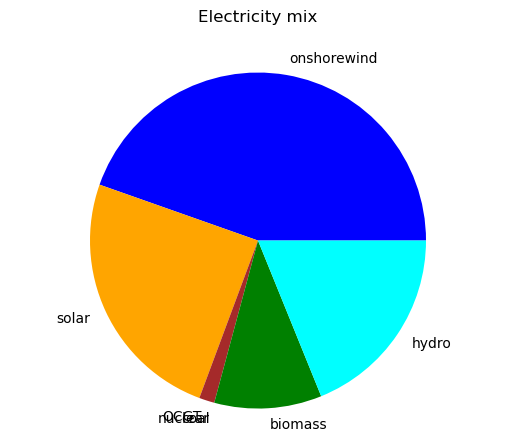

In [20]:
sizes_F = [np.array([network_F.generators_t.p[f"{country} {tech}"].sum()
        for country in countries]).sum()
        for tech in techs_labels]
sizes_F_hydro = network_F.links_t.p0[[f"{hydro_country} hydro2p" for hydro_country in hydro_countries]].sum().sum()
sizes_F.append(sizes_F_hydro)

plt.pie(sizes_F,
        colors=techs_colors+[network_F.carriers.color['water']],
        labels=techs_labels+['hydro'],
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)
plt.savefig('results/F/electricity_mix.png', dpi=500)

In [21]:
np.array(sizes_F) / 1e6

array([425.56967433, 235.8737829 ,  14.13488263,   0.        ,
         0.        ,  98.57322767, 179.9724497 ])

In [22]:
network_F.generators.p_nom_opt.div(1e3).groupby(network_F.generators.carrier).sum()  # MW -> GW

carrier
coal             0.000000
gas             38.249693
nuclear          0.000000
onshorewind    177.307460
solar          204.532570
wood chips      25.402287
Name: p_nom_opt, dtype: float64

In [23]:
network_F.storage_units.p_nom_opt.div(1e3)  # MW -> GW

StorageUnit
GBR Carnot battery (Molten salt)     3.697322
GBR Li-ion battery                   0.000000
GBR  Vanadium rfb                    0.000000
FRA Carnot battery (Molten salt)    40.465921
FRA Li-ion battery                   0.000000
FRA  Vanadium rfb                    0.000000
NOR Carnot battery (Molten salt)     1.765180
NOR Li-ion battery                   0.000000
NOR  Vanadium rfb                    0.000000
Name: p_nom_opt, dtype: float64

In [24]:
network_F.storage_units.p_nom_opt.div(1e3).sum()

45.92842266791147

In [25]:
network_F.lines.s_nom_opt.div(1e3)  # MW -> GW

Line
(GBR,FRA)    28.001281
(GBR,NOR)    36.084134
Name: s_nom_opt, dtype: float64

In [26]:
network_F.links.p_nom_opt.div(1e3)[network_F.links.p_nom==0]  # MW -> GW

Link
FRA hydro2p     8.787
NOR hydro2p    26.712
Name: p_nom_opt, dtype: float64

In [27]:
network_F.links.p_nom_opt.div(1e3)[network_F.links.p_nom==0].sum()

35.499

In [28]:
# emissions by CARRIER
emissions = (
    network_F.generators_t.p
    / network_F.generators.efficiency
    * network_F.generators.carrier.map(network_F.carriers.co2_emissions)
).T.groupby(network_F.generators.carrier).sum().T  # t/h
emissions.sum().div(1e6), emissions.sum().div(1e6).sum().round(3)  # tCO2 -> MtCO2

(carrier
 coal           0.000
 gas            5.936
 nuclear        0.000
 onshorewind    0.000
 solar          0.000
 wood chips     0.000
 dtype: float64,
 5.936)

In [29]:
np.array([network_F.generators_t.p[f"{country} biomass"].sum() for country in countries]).sum() / 10**6, biomass_available / 10**6 * dict_efficiencies['biomass']  # in TWh. Compare the biomass used to the biomass available to verify if we are using everything

(98.57322767048333, 98.57322767051916)

/opt/anaconda3/envs/integrated-energy-grids/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


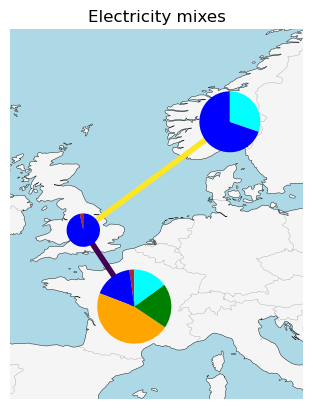

/opt/anaconda3/envs/integrated-energy-grids/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


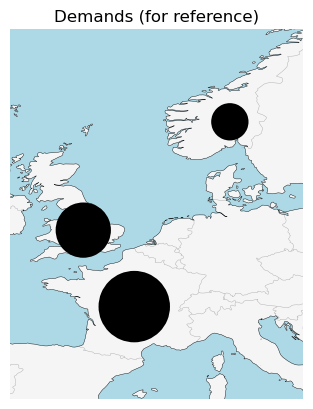

/opt/anaconda3/envs/integrated-energy-grids/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


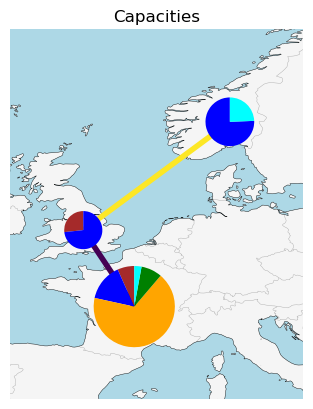

In [30]:
sizes_F_ind_gen = network_F.generators_t.p.sum().groupby([network_F.generators.bus, network_F.generators.carrier]).sum()
sizes_F_ind_hydro = network_F.links_t.p0.sum().groupby([network_F.links.bus1, network_F.links.carrier]).sum()[(network_F.links.p_nom == 0).values]
sizes_F_ind = pd.concat([sizes_F_ind_gen, sizes_F_ind_hydro])
ax = network_F.plot(margin=0.5,
                    bus_sizes=sizes_F_ind / 6e7,
                    color_geomap=True,
                    line_widths=4,
                    line_colors=network_F.lines_t.p0.abs().mean(),
)
plt.title("Electricity mixes")
plt.savefig('results/F/electricity_mixes_map.png', dpi=500)
plt.show()

sizes_F_load = network_F.loads_t.p.sum().groupby([network_F.loads.bus, network_F.loads.carrier]).sum()
ax = network_F.plot(margin=0.5,
                    bus_sizes=sizes_F_load / 6e7,
                    color_geomap=True,
                    line_widths=0,
                    line_colors=network_F.lines.s_nom_opt,
)
plt.title("Demands (for reference)")
plt.savefig('results/F/Demands_map.png', dpi=500)
plt.show()

sizes_F_ind_gen_nom = network_F.generators.p_nom_opt.groupby([network_F.generators.bus, network_F.generators.carrier]).sum()
sizes_F_ind_hydro_nom = network_F.links.p_nom_opt.groupby([network_F.links.bus1, network_F.links.carrier]).sum()[(network_F.links.p_nom == 0).values]
sizes_F_ind_nom = pd.concat([sizes_F_ind_gen_nom, sizes_F_ind_hydro_nom])
ax = network_F.plot(margin=0.5,
                    bus_sizes=sizes_F_ind_nom / 3e4,
                    color_geomap=True,
                    line_widths=4,
                    line_colors=network_F.lines.s_nom_opt,
)
plt.title("Capacities")
plt.savefig('results/F/capacities_map.png', dpi=500)
plt.show()

In [31]:
# Congestion rent
-np.round(np.array([network_F.lines_t.p0[f"({line_pair[0]},{line_pair[1]})"].multiply(
    network_F.buses_t.marginal_price[f"{line_pair[0]} electricity bus"]
    -network_F.buses_t.marginal_price[f"{line_pair[1]} electricity bus"]
).sum() / 1e6
for line_pair in line_pairs]).sum(),3)

5044.969

In [32]:
# Total expenditures, of which 'AC' is transmission and storage:
tot_expenditures=(network_F.statistics.capex(groupby="carrier").add(
    network_F.statistics.opex(groupby="carrier"), fill_value=0
    )
).div(1e6).round(3)  # € -> M€
tot_expenditures, tot_expenditures.sum(), network_F.objective/1e6

(component    carrier    
 Generator    gas             2745.242
              onshorewind    19618.064
              solar           4700.170
              wood chips      9166.998
 Line         AC              5044.969
 Link         water           3873.965
 StorageUnit  AC              1704.938
 dtype: float64,
 46854.346,
 46854.34629912516)

In [33]:
# Storage profits
bus_price = network_F.buses_t.marginal_price
stor_p = network_F.storage_units_t.p
stor_bus = network_F.storage_units.bus
( stor_p * bus_price[stor_bus].to_numpy() ).sum().div(1e6).round(3).sum()  # € -> M€

1704.938

In [34]:
# Generator profits by CARRIER and GENERATOR, respectively
gen_p = network_F.generators_t.p
gen_bus = network_F.generators.bus

( gen_p * bus_price[gen_bus].to_numpy() ).sum().div(1e6).groupby(network_F.generators.carrier).sum().round(3), ( gen_p * bus_price[gen_bus].to_numpy() ).sum().div(1e6).round(3)  # € -> M€

(carrier
 coal               0.000
 gas             4593.442
 nuclear            0.000
 onshorewind    19618.064
 solar           4700.170
 wood chips     10973.219
 dtype: float64,
 Generator
 GBR onshorewind     5444.157
 GBR solar              0.000
 GBR OCGT            1448.903
 GBR coal               0.000
 GBR nuclear            0.000
 GBR biomass            0.000
 FRA onshorewind     5012.774
 FRA solar           4700.170
 FRA OCGT            3144.539
 FRA coal               0.000
 FRA nuclear            0.000
 FRA biomass        10973.219
 NOR onshorewind     9161.134
 NOR solar              0.000
 NOR OCGT               0.000
 NOR coal               0.000
 NOR nuclear            0.000
 NOR biomass            0.000
 dtype: float64)

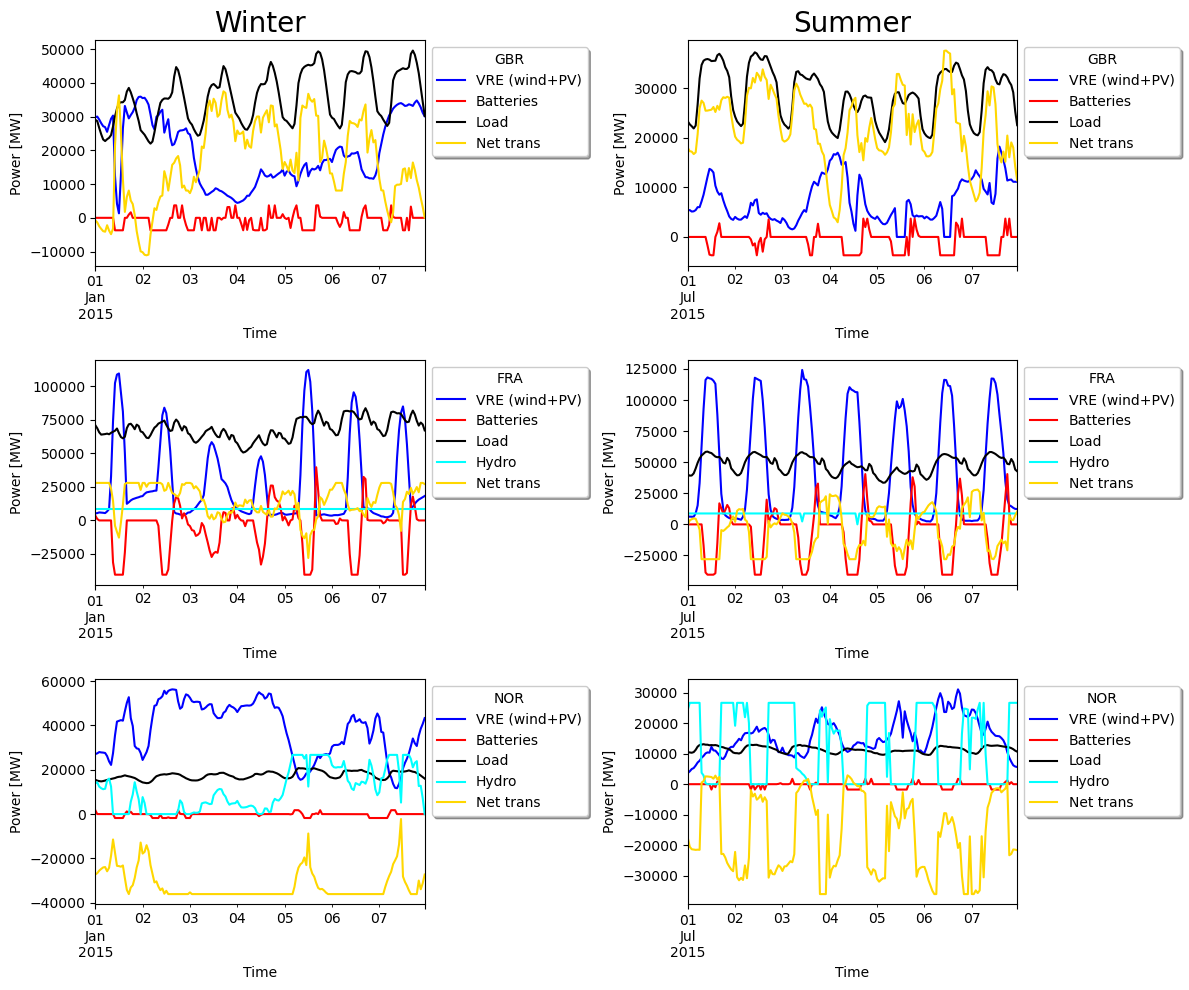

In [35]:
start_dates = ["2015-01-01", "2015-07-01"]
end_dates = ["2015-01-07", "2015-07-07"]
seasons = ['Winter', 'Summer']

storage_colors = ['red', 'yellow','pink']

net_transmission = {country: {season: pd.Series(0, index=network_F.lines_t.p0.loc[start_dates[j]:end_dates[j]].index) for j, season in enumerate(seasons)} for country in countries}

fig, ax = plt.subplots(len(countries),len(seasons),figsize=(12,10))
for j, season in enumerate(seasons):
    for i, country in enumerate(countries):

        #Plot VRE production
        network_F.generators_t.p.loc[start_dates[j]:end_dates[j]][[f"{country} {tech}" for tech in VRE_techs]].T.sum().plot(
            ax=ax[i,j],
            label="VRE (wind+PV)",
            color=network_F.generators.carrier.map(network_F.carriers.color)[f"{country} {VRE_techs[0]}"],  # choose solar or wind color
            legend=False)
        # network_F.generators_t.p.loc[start_dates[j]:end_dates[j]][[f"{country} {tech}" for tech in VRE_techs]].plot(ax=ax[i], legend=False)  # to see VREs separately
        
        # # Plot biomass production
        # network_F.generators_t.p.loc[start_dates[j]:end_dates[j]][[f"{country} {tech}" for tech in techs_labels if tech not in VRE_techs]].T.sum().plot(
        #     ax=ax[i,j],
        #     label="Dispatchable plants",
        #     color=network_F.generators.carrier.map(network_F.carriers.color)[f"{country} biomass"],  # get green
        #     legend=False)

        # Plot battery dispatch
        network_F.storage_units_t.p.loc[start_dates[j]:end_dates[j]][[f"{country} {stor}" for stor in techs_labels_storageunits]].T.sum().plot(
            ax=ax[i,j],
            label="Batteries",
            color=storage_colors[0], # oops, the carriers for storages are not defined #network_F.storage_units.carrier.map(network_F.carriers.color)[f"{country} {techs_labels_storageunits[-1]}"],  # choose one of their colors
            legend=False)
        
        # Plot the demand that has to be met
        network_F.loads_t.p.loc[start_dates[j]:end_dates[j]][f"{country} electricity load"].plot(
            ax=ax[i,j],
            label="Load",
            color=network_F.loads.carrier.map(network_F.carriers.color)[f"{country} electricity load"],
            legend=False)
        
        # Plot the hydro dispatch
        if country in hydro_countries:
            network_F.links_t.p0.T[(network_F.links.p_nom == 0).values].T.loc[start_dates[j]:end_dates[j]][f"{country} hydro2p"].plot(
                ax=ax[i,j],
                label="Hydro",
                color=network_F.links.carrier.map(network_F.carriers.color)[f"{country} hydro2p"],
                legend=False)  # p_nom==0 because we don't care about "dummy" links
        
        combined_export = pd.Series(0, index=network_F.lines_t.p0.loc[start_dates[j]:end_dates[j]].index)
        combined_import = pd.Series(0, index=network_F.lines_t.p0.loc[start_dates[j]:end_dates[j]].index)

        for bus0, bus1 in line_pairs:
            if bus0 == country:
                combined_export += network_F.lines_t.p0.loc[start_dates[j]:end_dates[j]][f"({bus0},{bus1})"]
            if bus1 == country:
                combined_import += network_F.lines_t.p0.loc[start_dates[j]:end_dates[j]][f"({bus0},{bus1})"]

        # Plot the transfer of power
        net_transmission[country][season] = combined_import - combined_export
        net_transmission[country][season].plot(
            ax=ax[i,j],
            label="Net trans",
            color='gold',
            legend=False
            )

        ax[i,j].legend(loc='best', fancybox=True, shadow=True, bbox_to_anchor=(1, 1), prop={'size': 10}, title=f"{country}")
        ax[i,j].set_ylabel('Power [MW]')
        ax[i,j].set_xlabel('Time')
        if i == 0:
            ax[i,j].set_title(f"{season}", fontsize=20)
plt.tight_layout()
plt.savefig(f'results/F/dispatch', dpi=500)
plt.show()


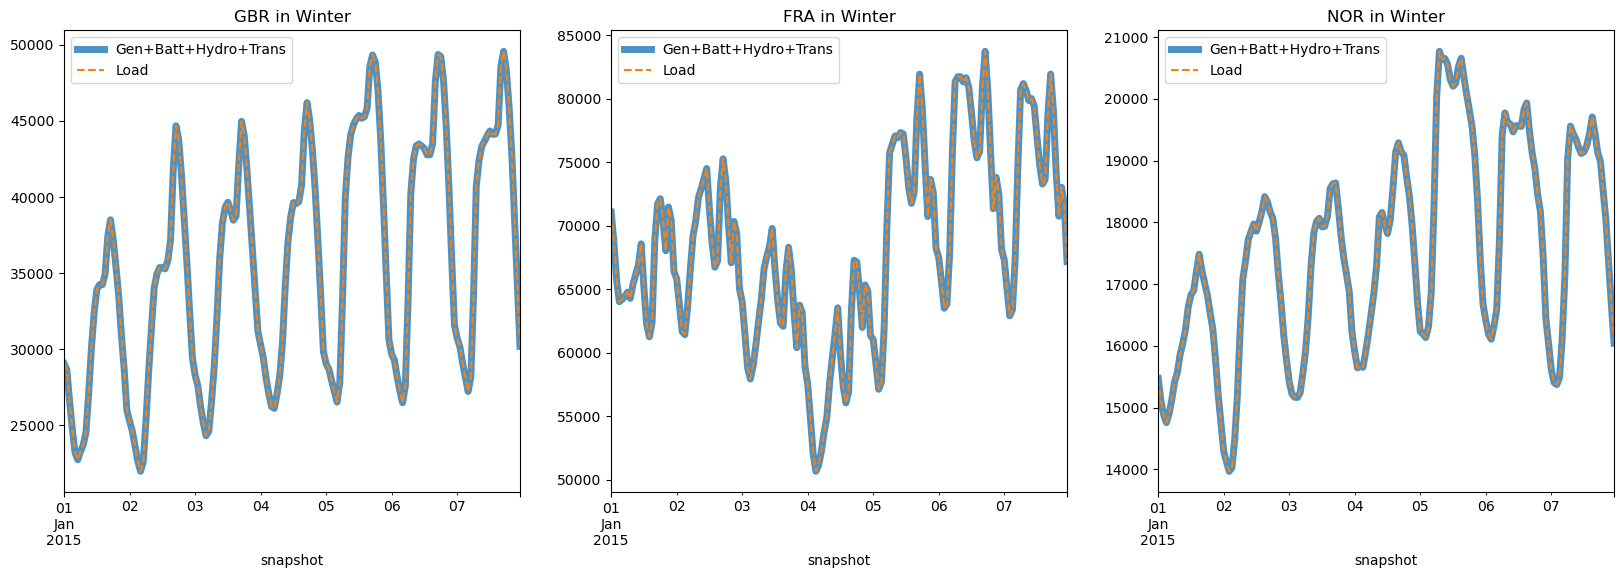

In [36]:
season_idx = 0

fig, ax = plt.subplots(1,3, figsize=(20,6))

for i, country in enumerate(countries):
    balance = pd.Series(0, index=network_F.lines_t.p0.loc[start_dates[season_idx]:end_dates[season_idx]].index)

    # Add generator production
    balance += network_F.generators_t.p.loc[start_dates[season_idx]:end_dates[season_idx]][[f"{country} {tech}" for tech in techs_labels]].T.sum()

    # Add battery dispatch
    balance += network_F.storage_units_t.p.loc[start_dates[season_idx]:end_dates[season_idx]][[f"{country} {stor}" for stor in techs_labels_storageunits]].T.sum()

    # Add hydro dispatch
    if country in hydro_countries:
        balance += network_F.links_t.p0.T[(network_F.links.p_nom == 0).values].T.loc[start_dates[season_idx]:end_dates[season_idx]][f"{country} hydro2p"]

    # Add the net transmission
    balance += net_transmission[country][seasons[season_idx]]

    balance.plot(
        ax=ax[i],
        label="Gen+Batt+Hydro+Trans",
        linewidth=5,
        alpha=.8)
    network_F.loads_t.p.loc[start_dates[season_idx]:end_dates[season_idx]][f"{country} electricity load"].plot(
        ax=ax[i],
        label="Load",
        linestyle="--")
    ax[i].legend()
    ax[i].set_title(f"{country} in {seasons[season_idx]}")

In [37]:
network_F.loads_t.p.sum().sum() / network_F.loads_t.p.sum()["GBR electricity load"]

3.125826248582856

# G.
### Connect the electricity sector with, at least, another sector( e.g. heating or transport), and co-optimize all the sectors. Discuss your results.

<Axes: title={'center': 'Heat demand'}, xlabel='utc_time', ylabel='MW'>

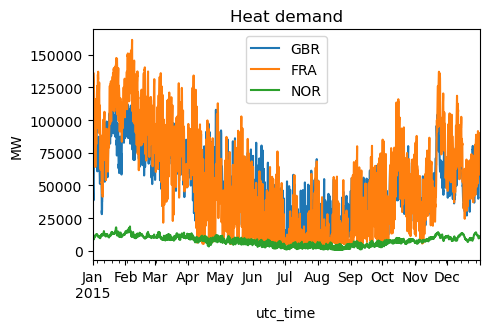

In [38]:
#connect the electricity sector with a heating sector. 

network_G = network_F.copy(network_F.snapshots)


#Load heat demand data
df_heat = pd.read_csv('data/heat_demand.csv', sep=';', index_col=0) # in MWh
df_heat.index = pd.to_datetime(df_heat.index) #change index to datatime

#load temperature data
#df_temp = pd.read_csv('data/temperature.csv', sep=';', index_col=0) # in MWh
#df_temp.index = pd.to_datetime(df_temp.index) #change index to datatime

df_heat[countries].plot(title='Heat demand',ylabel=('MW'),figsize=(5,3))
#df_temp[countries].plot(title='Temperature',ylabel=('MW'),figsize=(5,3))

In [39]:
network_G.add("Carrier",
              "heat",
              color='red',
              co2_emissions=0,
              track_biomass=0,
              overwrite=True)

# Define heat demand
for country in countries:
    network_G.add("Bus",
                  f"{country} heat bus",
                  y=country_coords[country][0],
                  x=country_coords[country][1],
                  overwrite=True,)
    network_G.add("Load",
                  f"{country} heat load",
                  carrier="heat",
                  bus=f"{country} heat bus",
                  p_set=df_heat[country].values,
                  overwrite=True)

In [40]:
HP_lifetime = 25  # HP values are from the DEA techology catalogue "Comp. HP airsouce 10 MW"
HP_capital_cost = 0.91*1e6  # M€/MW -> €/MW
HP_COP = 3.5
HP_annualized_capital_cost=f.annuity(HP_lifetime, 0.07)*HP_capital_cost*(1+0.03)
HP_annualized_capital_cost

80430.19779092987

In [41]:
#Add chp to the network

    # We add a gas store with energy capacity and an initial filling level much higher than the required gas consumption, 
    # this way gas supply is unlimited

    #CHP VALUES FROM WEEK 11 CONSIDER CHANGING


# Add CHP to the network
for country in countries:
    network_G.add("Bus",
                  f"{country} biomass bus",
                  y=country_coords[country][0],
                  x=country_coords[country][1],
                  carrier="wood chips",
                  overwrite=True)  # Ensure gas buses are defined
    network_G.add("Store",
                  "biomass",
                  e_initial=biomass_available,  # to avoid instability??
                  e_nom=biomass_available,
                  bus=f"{country} biomass bus",
                  overwrite=True)
    network_G.add("Link", 
                  f"{country} CHP", 
                  bus0=f"{country} biomass bus",
                  bus1=f"{country} electricity bus",  # Ensure electricity bus is correctly referenced
                  bus2=f"{country} heat bus",
                  carrier="wood chips",
                  p_nom_extendable=True, 
                  capital_cost=dict_capital_costs_annualized['biomass'],
                  marginal_cost=dict_marginal_costs['biomass'], 
                  efficiency=0.4, 
                  efficiency2=0.4,
                  overwrite=True)

# Add heat pumps to the network
for country in countries:
    network_G.add("Link",
                  f"{country} heat pump",
                  carrier="heat",
                  bus0=f"{country} electricity bus",  # Ensure electricity bus is correctly referenced
                  bus1=f"{country} heat bus",
                  efficiency=HP_COP,  # Electricity to heat: COP ~ 3
                  p_nom_extendable=True,
                  capital_cost=HP_annualized_capital_cost,  # €/MW/a - taken from exercises in week 11
                  overwrite=True)

In [42]:
network_G.lines["s_nom_extendable"] = False
network_G.lines

,bus0,bus1,type,x,r,g,b,s_nom,s_nom_mod,s_nom_extendable,...,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt,v_nom
Line,,,,,,,,,,,,,,,,,,,,,
"(GBR,FRA)",GBR electricity bus,FRA electricity bus,,1.0,1.0,0.0,0.0,0.0,0.0,False,...,inf,0,1.0,1.0,0.0,0.0,1.0,1.0,28001.280904,1.0
"(GBR,NOR)",GBR electricity bus,NOR electricity bus,,1.0,1.0,0.0,0.0,0.0,0.0,False,...,inf,0,1.0,1.0,0.0,0.0,1.0,1.0,36084.134341,1.0


In [43]:
network_G.optimize(solver_name='gurobi', solver_options={"env": env})
# network_G.optimize(
#     solver_name="gurobi",
#     solver_options={
#         "Method": 2,        # Use barrier
#         "Crossover": 0,     # Disable crossover
#         "NumericFocus": 3   # Help with numerical stability
#     }
# )

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 12/12 [00:01<00:00,  8.95it/s]
INFO:linopy.io: Writing time: 11.52s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 586957 primals, 1322801 duals
Objective: 9.62e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Line-fix-s-lower, Line-fix-s-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

In [44]:
network_G.objective/1e9  # € -> b€ -- it was 47.935 b€ before adding hydro for France :O ... 42.82 before adding CO2 constraint

96.16973168847917

In [45]:
network_G.generators.p_nom_opt.div(1e3).groupby(network_G.generators.carrier).sum()

carrier
coal             0.000000
gas             58.316555
nuclear         16.980888
onshorewind    278.781813
solar          613.835586
wood chips      54.158900
Name: p_nom_opt, dtype: float64

In [46]:
network_G.links.p_nom_opt.div(1e3)[network_G.links.p_nom==0]

Link
FRA hydro2p       8.787000
NOR hydro2p      20.322437
GBR CHP           0.000000
FRA CHP           0.000000
NOR CHP           0.000000
GBR heat pump    33.679016
FRA heat pump    46.094106
NOR heat pump     5.332221
Name: p_nom_opt, dtype: float64

In [47]:
network_G.lines.s_nom_opt

Line
(GBR,FRA)    0.0
(GBR,NOR)    0.0
Name: s_nom_opt, dtype: float64

In [48]:
# Why do we invest in pure-electricity biomass?
network_G.generators.loc[[f"{country} biomass" for country in countries]].capital_cost, network_G.generators.loc[[f"{country} biomass" for country in countries]].marginal_cost, network_G.generators.loc[[f"{country} biomass" for country in countries]].efficiency

(Generator
 GBR biomass    273992.981486
 FRA biomass    273992.981486
 NOR biomass    273992.981486
 Name: capital_cost, dtype: float64,
 Generator
 GBR biomass    22.388934
 FRA biomass    22.388934
 NOR biomass    22.388934
 Name: marginal_cost, dtype: float64,
 Generator
 GBR biomass    0.305
 FRA biomass    0.305
 NOR biomass    0.305
 Name: efficiency, dtype: float64)

In [49]:
#  CHP and pure-el biomass cost the same but CHP is more effective for electricity. It seems a little odd not to invest in CHP then.
network_G.links.loc[[f"{country} CHP" for country in countries]].capital_cost, network_G.links.loc[[f"{country} CHP" for country in countries]].marginal_cost, network_G.links.loc[[f"{country} CHP" for country in countries]].efficiency

(Link
 GBR CHP    273992.981486
 FRA CHP    273992.981486
 NOR CHP    273992.981486
 Name: capital_cost, dtype: float64,
 Link
 GBR CHP    22.388934
 FRA CHP    22.388934
 NOR CHP    22.388934
 Name: marginal_cost, dtype: float64,
 Link
 GBR CHP    0.4
 FRA CHP    0.4
 NOR CHP    0.4
 Name: efficiency, dtype: float64)

In [50]:
network_G.storage_units.p_nom_opt.div(1e3)

StorageUnit
GBR Carnot battery (Molten salt)     71.073123
GBR Li-ion battery                    0.000000
GBR  Vanadium rfb                     0.000000
FRA Carnot battery (Molten salt)    140.974809
FRA Li-ion battery                    0.000000
FRA  Vanadium rfb                     0.000000
NOR Carnot battery (Molten salt)      1.929524
NOR Li-ion battery                    0.000000
NOR  Vanadium rfb                     0.000000
Name: p_nom_opt, dtype: float64

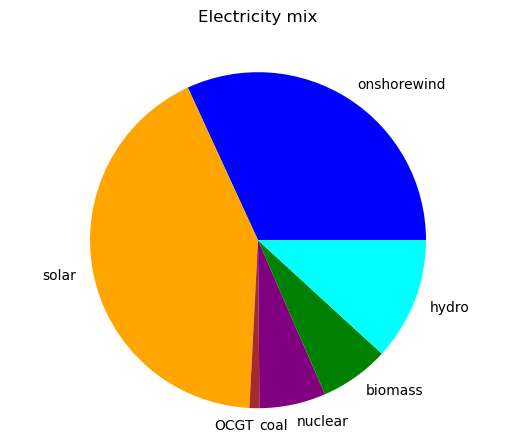

In [51]:
sizes_G = [np.array([network_G.generators_t.p[f"{country} {tech}"].sum()
        for country in countries]).sum()
        for tech in techs_labels]
sizes_G_hydro = network_G.links_t.p0[[f"{hydro_country} hydro2p" for hydro_country in hydro_countries]].sum().sum()
sizes_G.append(sizes_G_hydro)

plt.pie(sizes_G,
        colors=techs_colors+[network_G.carriers.color['water']],
        labels=techs_labels+['hydro'],
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)
plt.savefig('results/G/electricity_mix.png', dpi=500)

In [52]:
np.array(sizes_G) / 1e6

array([471.29753498, 626.04939413,  14.13488263,   0.        ,
        94.52774637,  98.57322767, 174.6613341 ])

In [53]:
network_G.links_t.p0.sum().loc[[f"{country} CHP" for country in countries]].sum()

0.0

In [54]:
network_G.links_t.p0.sum().loc[[f"{country} CHP" for country in countries]]

Link
GBR CHP    0.0
FRA CHP    0.0
NOR CHP    0.0
dtype: float64

# H: We add a constraint that **on average (annually)** a country should be self-sufficient

In [55]:
network_H = network_F.copy(network_F.snapshots)

# Allow us to work with custom constraints
network_H.optimize.create_model()
print()  # to avoid a long prompt from above

In [56]:
# Make a LHS consisting of the generation in each country
proxy_for_co2_emissions = np.ones(len(techs_labels))  # see the example below to understand what I mean. We do not actually care about CO2 emissions for the constraint that we are implementing in H
lhs_gen = (network_H.model.variables["Generator-p"].sum("snapshot")
* np.tile(proxy_for_co2_emissions, len(countries))).groupby(network_H.generators.bus.to_xarray()).sum()
lhs_gen

LinearExpression [bus: 3]:
--------------------------
[FRA electricity bus]: +1 Generator-p[2015-01-01 00:00:00, FRA onshorewind] + 1 Generator-p[2015-01-01 00:00:00, FRA solar] + 1 Generator-p[2015-01-01 00:00:00, FRA OCGT] ... +1 Generator-p[2015-12-31 23:00:00, FRA coal] + 1 Generator-p[2015-12-31 23:00:00, FRA nuclear] + 1 Generator-p[2015-12-31 23:00:00, FRA biomass]
[GBR electricity bus]: +1 Generator-p[2015-01-01 00:00:00, GBR onshorewind] + 1 Generator-p[2015-01-01 00:00:00, GBR solar] + 1 Generator-p[2015-01-01 00:00:00, GBR OCGT] ... +1 Generator-p[2015-12-31 23:00:00, GBR coal] + 1 Generator-p[2015-12-31 23:00:00, GBR nuclear] + 1 Generator-p[2015-12-31 23:00:00, GBR biomass]
[NOR electricity bus]: +1 Generator-p[2015-01-01 00:00:00, NOR onshorewind] + 1 Generator-p[2015-01-01 00:00:00, NOR solar] + 1 Generator-p[2015-01-01 00:00:00, NOR OCGT] ... +1 Generator-p[2015-12-31 23:00:00, NOR coal] + 1 Generator-p[2015-12-31 23:00:00, NOR nuclear] + 1 Generator-p[2015-12-31 23:00:

In [57]:

lhs_hydro = (network_H.model.variables["Link-p"].sum("snapshot")[[0,2]]
             * np.tile(1, len(hydro_countries))
             ).groupby(
                 network_H.links.bus1.T[[f"{hydro_country} hydro2p" for hydro_country in hydro_countries]].T.to_xarray()
                 ).sum()  # removing "dummy" links manually
lhs_hydro = lhs_hydro.rename({'bus1':'bus'})  # aligns the "LinearExpression" dimensions of lhs_gen and lhs_hydro
lhs_hydro

LinearExpression [bus: 2]:
--------------------------
[FRA electricity bus]: +1 Link-p[2015-01-01 00:00:00, FRA hydro2p] + 1 Link-p[2015-01-01 01:00:00, FRA hydro2p] + 1 Link-p[2015-01-01 02:00:00, FRA hydro2p] ... +1 Link-p[2015-12-31 21:00:00, FRA hydro2p] + 1 Link-p[2015-12-31 22:00:00, FRA hydro2p] + 1 Link-p[2015-12-31 23:00:00, FRA hydro2p]
[NOR electricity bus]: +1 Link-p[2015-01-01 00:00:00, NOR hydro2p] + 1 Link-p[2015-01-01 01:00:00, NOR hydro2p] + 1 Link-p[2015-01-01 02:00:00, NOR hydro2p] ... +1 Link-p[2015-12-31 21:00:00, NOR hydro2p] + 1 Link-p[2015-12-31 22:00:00, NOR hydro2p] + 1 Link-p[2015-12-31 23:00:00, NOR hydro2p]

In [58]:
lhs_combined = lhs_gen + lhs_hydro
lhs_combined

LinearExpression [bus: 3]:
--------------------------
[FRA electricity bus]: +1 Generator-p[2015-01-01 00:00:00, FRA onshorewind] + 1 Generator-p[2015-01-01 00:00:00, FRA solar] + 1 Generator-p[2015-01-01 00:00:00, FRA OCGT] ... +1 Link-p[2015-12-31 21:00:00, FRA hydro2p] + 1 Link-p[2015-12-31 22:00:00, FRA hydro2p] + 1 Link-p[2015-12-31 23:00:00, FRA hydro2p]
[GBR electricity bus]: +1 Generator-p[2015-01-01 00:00:00, GBR onshorewind] + 1 Generator-p[2015-01-01 00:00:00, GBR solar] + 1 Generator-p[2015-01-01 00:00:00, GBR OCGT] ... +1 Generator-p[2015-12-31 23:00:00, GBR coal] + 1 Generator-p[2015-12-31 23:00:00, GBR nuclear] + 1 Generator-p[2015-12-31 23:00:00, GBR biomass]
[NOR electricity bus]: +1 Generator-p[2015-01-01 00:00:00, NOR onshorewind] + 1 Generator-p[2015-01-01 00:00:00, NOR solar] + 1 Generator-p[2015-01-01 00:00:00, NOR OCGT] ... +1 Link-p[2015-12-31 21:00:00, NOR hydro2p] + 1 Link-p[2015-12-31 22:00:00, NOR hydro2p] + 1 Link-p[2015-12-31 23:00:00, NOR hydro2p]

In [59]:
rhs_raw = network_H.loads_t.p.sum().iloc[[1,0,2]]  # we re-order to match above
rhs = rhs_raw.values
rhs_raw

Load
FRA electricity load    471244680.0
GBR electricity load    282195189.0
NOR electricity load    128653260.0
dtype: float64

In [60]:
network_H.model.add_constraints(lhs_combined,
                                ">=",
                                rhs,
                                name="Self-sufficiency")
network_H.optimize.solve_model(solver_name='gurobi', solver_options={"env": env})

# Below works for implementing separate CO2-emissions limits.

# lhs = (network_H.model.variables["Generator-p"].sum("snapshot")
# / network_H.generators.efficiency.values
# * np.tile(network_H.carriers.co2_emissions[1:-1].values, len(countries))).groupby(network_H.generators.bus.to_xarray()).sum()
# # "[1:-1]" to skip AC and water carriers.
# rhs = np.array([4.2, 1.48, 0.14]) * 1e6  # tCO2

# network_H.model.add_constraints(lhs,
#                                 "<=",
#                                 rhs,
#                                 name="CO2Limit")
# network_H.optimize.solve_model(solver_name='gurobi', solver_options={"env": env})

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 13/13 [00:01<00:00, 10.42it/s]
INFO:linopy.io: Writing time: 19.7s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 516873 primals, 1138840 duals
Objective: 4.74e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Line-ext-s-lower, Line-ext-s-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

In [61]:
network_H.objective / 1e9  # b€

47.40711176625563

In [62]:
network_H.storage_units.p_nom_opt.groupby(network_H.storage_units.bus).sum()  # Only Carnot...

bus
FRA electricity bus    56643.668212
GBR electricity bus     5160.137270
NOR electricity bus      777.571184
Name: p_nom_opt, dtype: float64

In [63]:
network_H.lines.s_nom_opt

Line
(GBR,FRA)    40827.494852
(GBR,NOR)    25432.938670
Name: s_nom_opt, dtype: float64

In [64]:
# emissions by GENERATOR
emissions = (
    network_H.generators_t.p
    / network_H.generators.efficiency
    * network_H.generators.carrier.map(network_H.carriers[1:-1].co2_emissions)
)  # t/h
emissions.sum().div(1e6).groupby(network_H.generators.bus).sum()  # tCO2 -> MtCO2

bus
FRA electricity bus    1.068752
GBR electricity bus    4.867248
NOR electricity bus    0.000000
dtype: float64

In [65]:
network_H.generators_t.p.sum().groupby(network_H.generators.bus).sum().add(
    network_H.links_t.p0.T[(network_H.links.p_nom==0).values].T.sum().groupby(network_H.links.bus1).sum(),
    fill_value=0
).div(1e6)  # TWh

FRA electricity bus    471.244680
GBR electricity bus    282.195189
NOR electricity bus    227.833160
dtype: float64

In [66]:
network_H.loads_t.p.sum().div(1e6)  # TWh

Load
GBR electricity load    282.195189
FRA electricity load    471.244680
NOR electricity load    128.653260
dtype: float64

/opt/anaconda3/envs/integrated-energy-grids/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


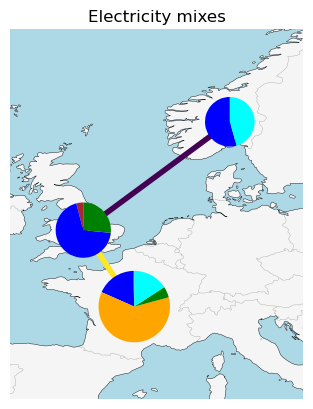

In [67]:
sizes_H_ind_gen = network_H.generators_t.p.sum().groupby([network_H.generators.bus, network_H.generators.carrier]).sum()
sizes_H_ind_hydro = network_H.links_t.p0.sum().groupby([network_H.links.bus1, network_H.links.carrier]).sum()[(network_H.links.p_nom == 0).values]
sizes_H_ind = pd.concat([sizes_H_ind_gen, sizes_H_ind_hydro])
ax = network_H.plot(margin=0.5,
                    bus_sizes=sizes_H_ind / 6e7,
                    color_geomap=True,
                    line_widths=4,
                    line_colors=network_H.lines_t.p0.abs().mean(),
)
plt.title("Electricity mixes")
plt.savefig('results/H/electricity_mixes_map.png', dpi=500)
plt.show()

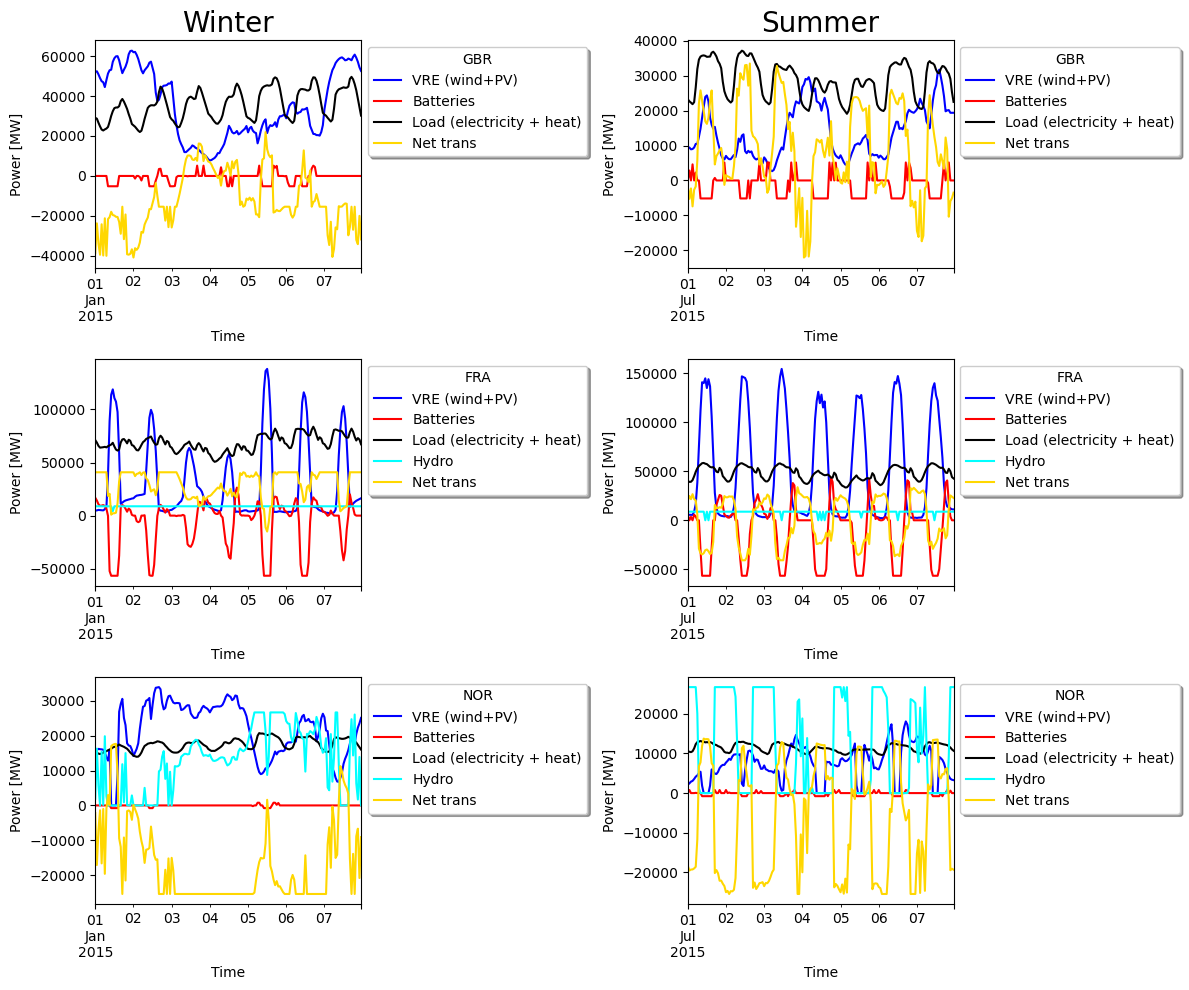

In [68]:
start_dates = ["2015-01-01", "2015-07-01"]
end_dates = ["2015-01-07", "2015-07-07"]
seasons = ['Winter', 'Summer']

storage_colors = ['red', 'yellow','pink']

net_transmission = {country: {season: pd.Series(0, index=network_H.lines_t.p0.loc[start_dates[j]:end_dates[j]].index) for j, season in enumerate(seasons)} for country in countries}

fig, ax = plt.subplots(len(countries),len(seasons),figsize=(12,10))
for j, season in enumerate(seasons):
    for i, country in enumerate(countries):

        #Plot VRE production
        network_H.generators_t.p.loc[start_dates[j]:end_dates[j]][[f"{country} {tech}" for tech in VRE_techs]].T.sum().plot(
            ax=ax[i,j],
            label="VRE (wind+PV)",
            color=network_H.generators.carrier.map(network_H.carriers.color)[f"{country} {VRE_techs[0]}"],  # choose solar or wind color
            legend=False)

        # Plot battery dispatch
        network_H.storage_units_t.p.loc[start_dates[j]:end_dates[j]][[f"{country} {stor}" for stor in techs_labels_storageunits]].T.sum().plot(
            ax=ax[i,j],
            label="Batteries",
            color=storage_colors[0], # oops, the carriers for storages are not defined #network_F.storage_units.carrier.map(network_F.carriers.color)[f"{country} {techs_labels_storageunits[-1]}"],  # choose one of their colors
            legend=False)
        
        # Plot the demand that has to be met
        network_H.loads_t.p.loc[start_dates[j]:end_dates[j]][f"{country} electricity load"].plot(
            ax=ax[i,j],
            label="Load (electricity + heat)",
            color=network_H.loads.carrier.map(network_H.carriers.color)[f"{country} electricity load"],
            legend=False)
        
        # Plot the hydro dispatch
        if country in hydro_countries:
            network_H.links_t.p0.T[(network_H.links.p_nom == 0).values].T.loc[start_dates[j]:end_dates[j]][f"{country} hydro2p"].plot(
                ax=ax[i,j],
                label="Hydro",
                color=network_H.links.carrier.map(network_H.carriers.color)[f"{country} hydro2p"],
                legend=False)  # p_nom==0 because we don't care about "dummy" links
        
        combined_export = pd.Series(0, index=network_H.lines_t.p0.loc[start_dates[j]:end_dates[j]].index)
        combined_import = pd.Series(0, index=network_H.lines_t.p0.loc[start_dates[j]:end_dates[j]].index)

        for bus0, bus1 in line_pairs:
            if bus0 == country:
                combined_export += network_H.lines_t.p0.loc[start_dates[j]:end_dates[j]][f"({bus0},{bus1})"]
            if bus1 == country:
                combined_import += network_H.lines_t.p0.loc[start_dates[j]:end_dates[j]][f"({bus0},{bus1})"]

        # Plot the transfer of power
        net_transmission[country][season] = combined_import - combined_export
        net_transmission[country][season].plot(
            ax=ax[i,j],
            label="Net trans",
            color='gold',
            legend=False
            )

        ax[i,j].legend(loc='best', fancybox=True, shadow=True, bbox_to_anchor=(1, 1), prop={'size': 10}, title=f"{country}")
        ax[i,j].set_ylabel('Power [MW]')
        ax[i,j].set_xlabel('Time')
        if i == 0:
            ax[i,j].set_title(f"{season}", fontsize=20)
plt.tight_layout()
plt.savefig(f'results/H/dispatch', dpi=500)
plt.show()


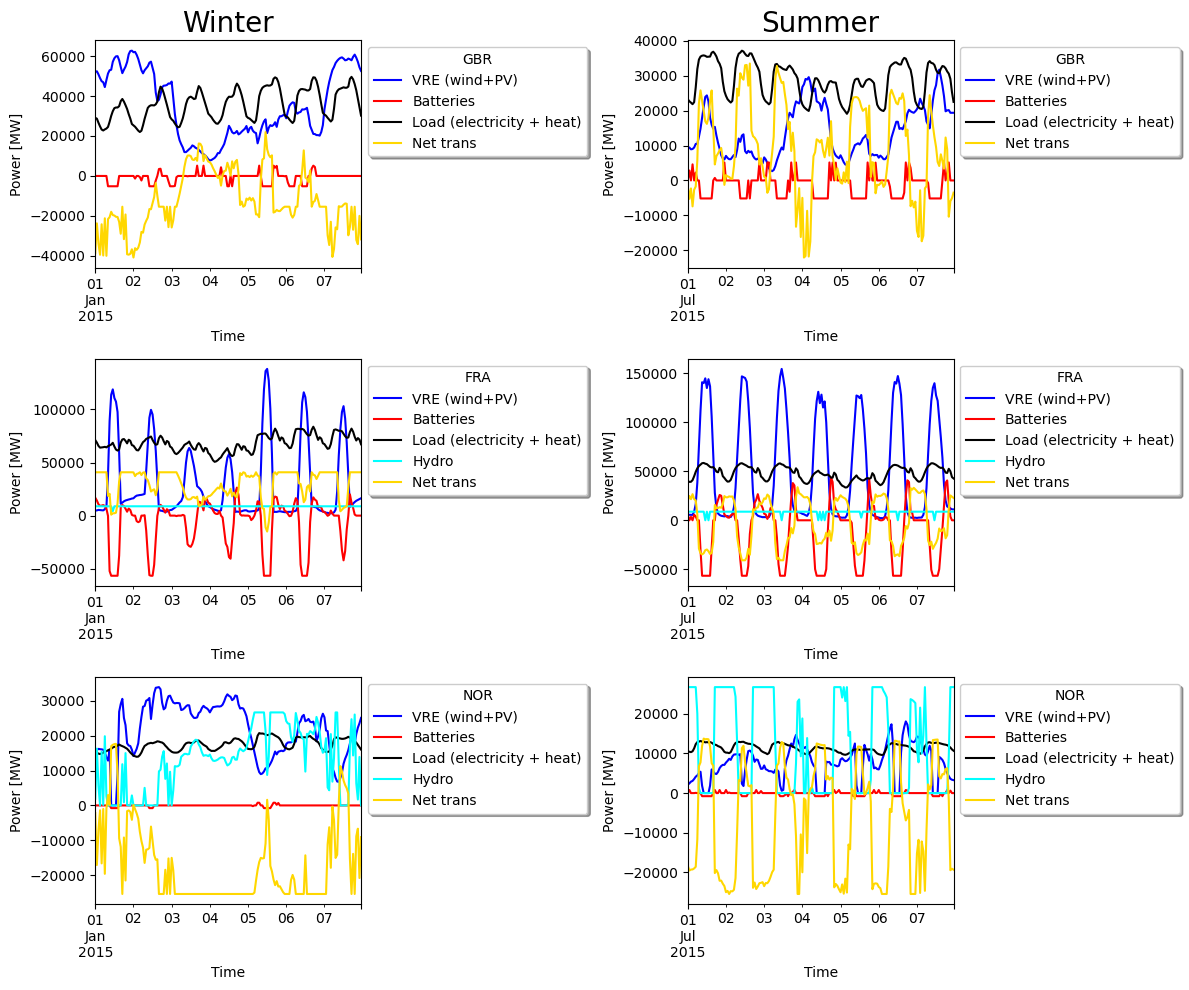

In [69]:
# Plot heat down here!

start_dates = ["2015-01-01", "2015-07-01"]
end_dates = ["2015-01-07", "2015-07-07"]
seasons = ['Winter', 'Summer']

storage_colors = ['red', 'yellow','pink']

net_transmission = {country: {season: pd.Series(0, index=network_H.lines_t.p0.loc[start_dates[j]:end_dates[j]].index) for j, season in enumerate(seasons)} for country in countries}

fig, ax = plt.subplots(len(countries),len(seasons),figsize=(12,10))
for j, season in enumerate(seasons):
    for i, country in enumerate(countries):

        #Plot VRE production
        network_H.generators_t.p.loc[start_dates[j]:end_dates[j]][[f"{country} {tech}" for tech in VRE_techs]].T.sum().plot(
            ax=ax[i,j],
            label="VRE (wind+PV)",
            color=network_H.generators.carrier.map(network_H.carriers.color)[f"{country} {VRE_techs[0]}"],  # choose solar or wind color
            legend=False)

        # Plot battery dispatch
        network_H.storage_units_t.p.loc[start_dates[j]:end_dates[j]][[f"{country} {stor}" for stor in techs_labels_storageunits]].T.sum().plot(
            ax=ax[i,j],
            label="Batteries",
            color=storage_colors[0], # oops, the carriers for storages are not defined #network_F.storage_units.carrier.map(network_F.carriers.color)[f"{country} {techs_labels_storageunits[-1]}"],  # choose one of their colors
            legend=False)
        
        # Plot the demand that has to be met
        network_H.loads_t.p.loc[start_dates[j]:end_dates[j]][f"{country} electricity load"].plot(
            ax=ax[i,j],
            label="Load (electricity + heat)",
            color=network_H.loads.carrier.map(network_H.carriers.color)[f"{country} electricity load"],
            legend=False)
        
        # Plot the hydro dispatch
        if country in hydro_countries:
            network_H.links_t.p0.T[(network_H.links.p_nom == 0).values].T.loc[start_dates[j]:end_dates[j]][f"{country} hydro2p"].plot(
                ax=ax[i,j],
                label="Hydro",
                color=network_H.links.carrier.map(network_H.carriers.color)[f"{country} hydro2p"],
                legend=False)  # p_nom==0 because we don't care about "dummy" links
        
        combined_export = pd.Series(0, index=network_H.lines_t.p0.loc[start_dates[j]:end_dates[j]].index)
        combined_import = pd.Series(0, index=network_H.lines_t.p0.loc[start_dates[j]:end_dates[j]].index)

        for bus0, bus1 in line_pairs:
            if bus0 == country:
                combined_export += network_H.lines_t.p0.loc[start_dates[j]:end_dates[j]][f"({bus0},{bus1})"]
            if bus1 == country:
                combined_import += network_H.lines_t.p0.loc[start_dates[j]:end_dates[j]][f"({bus0},{bus1})"]

        # Plot the transfer of power
        net_transmission[country][season] = combined_import - combined_export
        net_transmission[country][season].plot(
            ax=ax[i,j],
            label="Net trans",
            color='gold',
            legend=False
            )

        ax[i,j].legend(loc='best', fancybox=True, shadow=True, bbox_to_anchor=(1, 1), prop={'size': 10}, title=f"{country}")
        ax[i,j].set_ylabel('Power [MW]')
        ax[i,j].set_xlabel('Time')
        if i == 0:
            ax[i,j].set_title(f"{season}", fontsize=20)
plt.tight_layout()
plt.savefig(f'results/H/dispatch_heat', dpi=500)
plt.show()
